In [1]:
# for text processing
!pip -q install hazm
!pip -q install clean-text[gpl]
# eda
!pip install -U -q dataprep

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hazm 0.7.0 requires nltk==3.3, but you have nltk 3.7 which is incompatible.


In [2]:
# basic imports
import os
import gc, json
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go
from dataprep.eda import create_report
from IPython.display import display, HTML

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer

# for text cleaning
from hazm import Normalizer
from hazm import WordTokenizer
from cleantext import clean
import re

In [3]:
# concent to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# unzip dataset
!unzip /content/drive/MyDrive/review-datasets.zip -d /content
data_path = '/content/datasets/'

Archive:  /content/drive/MyDrive/review-datasets.zip
replace /content/datasets/reject_reasons_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/datasets/future_test.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/datasets/train.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
# load training data
train_df = pd.read_parquet(f'{data_path}train.parquet', engine='pyarrow')
print('number of examples in trainset: ', len(train_df))
train_df.head()

number of examples in trainset:  102371


interview_post  reject_reason_id  \
0  {"category": "apartment-sell", "description": ...                 0   
1  {"category": "apartment-sell", "description": ...               153   
2  {"category": "apartment-sell", "description": ...               150   
3  {"category": "apartment-sell", "description": ...               150   
4  {"category": "apartment-sell", "description": ...                 0   

  reject_reason_category review_label  
0                 accept       accept  
1            wrong_price       reject  
2             one_on_one       reject  
3             one_on_one       reject  
4                 accept       accept

In [6]:
# load test data: two compare avaliable features
# - we only see train_df but apply all transformation on both train_df nad test_df
test_df = pd.read_parquet(f'{data_path}future_test.parquet', engine='pyarrow')
print('number of examples in trainset: ', len(test_df))
test_df.head()

number of examples in trainset:  48877


interview_post  reject_reason_id  \
0  {"category": "apartment-sell", "description": ...                 0   
1  {"category": "apartment-sell", "description": ...                 0   
2  {"category": "apartment-sell", "description": ...                 0   
3  {"category": "apartment-sell", "description": ...                 0   
4  {"category": "apartment-sell", "description": ...                 0   

  reject_reason_category review_label  
0                 accept       accept  
1                 accept       accept  
2                 accept       accept  
3                 accept       accept  
4                 accept       accept

In [7]:
# healper funcion
def plot_distro(column, title='calsses'):
    fig = go.Figure()
    freq = column.value_counts()
    fig.add_trace(go.Bar(y=freq, x=freq.index.to_numpy().astype('str')))
    fig.update_layout(title_text=f'Distribution of {title}',
                      xaxis_title_text=title,
                      yaxis_title_text='Frequency',
                      bargap=0.2,
                      bargroupgap=0.2)
    return fig

# Plot Distribution of target variable
plot_distro(train_df.review_label).show()

In [8]:
plot_distro(train_df.reject_reason_category, title='reject reasons').show()

In [9]:
# take a look at reject reason descriptions
reason_df = pd.read_csv(f'{data_path}reject_reasons_info.csv', index_col=0)
print('# unique category: ', len(train_df.reject_reason_category.unique()))
print('# unique id: ', len(train_df.reject_reason_id.unique()))
# observation: 150 and 4664631 are the same (one_on_one)
# - after chechking some examples of both 
reason_df

# unique category:  7
# unique id:  8


reject_reason_id   reject_reason_category  \
0                 0                   accept   
1               146           wrong_category   
2               150               one_on_one   
3               151               wrong_city   
4               153              wrong_price   
5               161  critics_and_suggestions   
6           4664631               one_on_one   
7          10521828                  buy_add   

                                  reject_reason_desc  
0                                                NaN  
1                               دسته‌بندی اشتباه است  
2  لطفا در هر آگهی مشخصات یک ملک را وارد کنید. هم...  
3  شهر انتخاب شده اشتباه است؛ لطفا با جست‌وجو در ...  
4  قیمت وارد شده اشتباه است. فیلد قیمت باید با قی...  
5  در آگهی شما ملک یا خدماتی مشخص نشده است؛ لطفاً...  
6  عنوان و توضیحات آگهی باید به طور مشخص به یک مل...  
7  امکان انتشار آگهی درخواست ملک وجود ندارد. با ا...

In [10]:
# parse the interview_post column to a pd.DataFrame 
train_feature_df = pd.json_normalize(train_df.interview_post.apply(lambda x: json.loads(x)))
test_feature_df = pd.json_normalize(test_df.interview_post.apply(lambda x: json.loads(x)))
print('# number of features: ', len(train_feature_df.columns))
# add parsed features to dataframes and remove interview_post column (unparsed features)
train_df = pd.concat([train_feature_df, train_df.drop(['interview_post'], axis=1)], axis=1)
test_df = pd.concat([test_feature_df, test_df.drop(['interview_post'], axis=1)], axis=1)

# number of features:  31


In [11]:
# check if any of the columns has the same value across all examples
redundant_columns = []
for col in train_df.columns:
    col_varibility = train_df[col].unique()
    if len(col_varibility) == 1: 
        print(f'{col} column only has {col_varibility}')
        redundant_columns.append(col)

# delete those columns
train_df = train_df.drop(redundant_columns, axis=1)
test_df = test_df.drop(redundant_columns, axis=1)

category column only has ['apartment-sell']


In [12]:
# we remove features that aren't available at test time
no_test_time = set(train_df.columns) - set(test_df.columns)
print("These features aren't available at inference:", no_test_time)

train_df = train_df.drop(no_test_time, axis=1)

These features aren't available at inference: {'exchange', 'post_type'}


In [13]:
# let's take a look at new columns
# obserevation: description and title are free-form text
train_df.head()

description elevator floor parking  \
0  سلام\nواحد تک خواب تمیز\nسند تک برگ آماده وام ...     true     0    true   
1  ⭐⭐⭐بسم الله الرحمن الرحیم ⭐⭐⭐\n\n⚜املاک فردیس ...     true     2    true   
2  با سلام \nتعدادی واحد در متراژ های ۹۰ و ۱۲۰ مت...     true     5    true   
3  پیش فروش ۲ واحد آپارتمان تک واحدی \n\n۳ خواب \...     true     2    true   
4  فروش فوری آپارتمان در گلسار بلوار سمیه  \n\n⭕️...     true     5    true   

  rooms  size                                   title    user_type warehouse  \
0    یک    60               آپارتمان نقلی، سند ششدانگ         شخصی      true   
1    دو    69         ۶۹متر واحد قریشی شمالی طبقه دوم  مشاور املاک      true   
2    دو   120     آپارتمان ۱۲۰ متری مسکن خیابان مطهری         شخصی      true   
3    سه   135   ۱۳۵ متر پیش فروش فول امکانات تک واحدی  مشاور املاک      true   
4    دو    92  فروش آپارتمان گلسار بلوار سمیه ٩٢ متری  مشاور املاک      true   

   year  ...  price.mode     new_price   price.value  \
0  ۱۳۸۸  ...      توافقی           NaN           NaN   
1  ۱۳۹۱  ...       مقطوع  3.000000e+08  3.000000e+08   
2  ۱۳۹۹  ...       مقطوع  1.000000e+09  1.000000e+09   
3  ۱۳۹۹  ...       مقطوع  2.497500e+09  2.497500e+09   
4  ۱۳۹۲  ...       مقطوع  1.900000e+09  1.900000e+09   

  other_options_and_attributes.toilet zoonkan_enabled national_id desc  \
0                                 NaN             NaN         NaN  NaN   
1                                 NaN             NaN         NaN  NaN   
2                                 NaN             NaN         NaN  NaN   
3                          squat_seat             NaN         NaN  NaN   
4                                 NaN             NaN         NaN  NaN   

  reject_reason_id reject_reason_category review_label  
0                0                 accept       accept  
1              153            wrong_price       reject  
2              150             one_on_one       reject  
3              150             one_on_one       reject  
4                0                 accept       accept  

[5 rows x 31 columns]

Automatic EDA: The following creates an automatic EDA report 
- w/o considering 'description' and 'title' columns
- the conclusions in the next cells are based on observation of this report


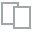
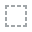
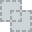
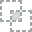
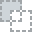
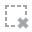
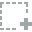
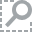
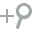
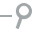
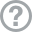
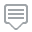
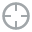
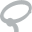
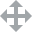
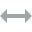
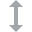
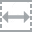
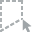
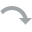
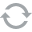
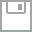
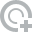
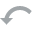
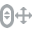
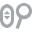
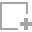
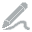
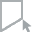
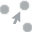
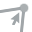
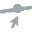

In [45]:
display(HTML('https://raw.githubusercontent.com/sajjjadayobi/utils/main/src/divar_report.html'))

ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'other_options...tem', 'other_options...ype'
ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'other_options...tem', 'other_options...ype'
ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'other_options...tem', 'other_options...ype'
The plot will not show in a notebook environment, please try 'show_browser' if you want to open it in browser


Report has been saved to divar_report.html!



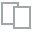
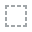
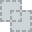
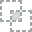
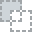
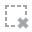
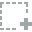
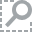
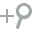
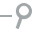
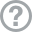
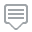
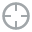
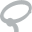
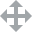
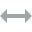
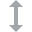
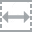
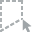
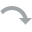
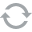
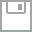
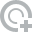
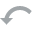
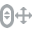
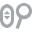
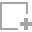
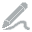
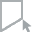
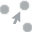
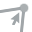
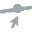

In [15]:
report = create_report(train_df.drop(['description', 'title'], axis=1))
report.save('divar_report.html')
report.show()

In [16]:
# observation based on EDA and Divar app: these coumns are 
# - optional in Divar app
# - more than 90% times missing (null)
# - don't correlate with ad acceptence
optional_columns = ['other_options_and_attributes.balcony', 'other_options_and_attributes.building_direction',
                      'other_options_and_attributes.cooling_system', 'other_options_and_attributes.deed_type',
                    'other_options_and_attributes.floor_type', 'other_options_and_attributes.floors_count',
                     'other_options_and_attributes.heating_system', 'other_options_and_attributes.rebuilt',
                     'other_options_and_attributes.unit_per_floor', 'other_options_and_attributes.warm_water_provider',
                    'other_options_and_attributes.toilet']
# so we drop all of them
train_df = train_df.drop(optional_columns, axis=1)
test_df = test_df.drop(optional_columns, axis=1)

In [17]:
# are price.value and new_price the same?
# observation: based on the correlation coefficient in EDA they seemed the same
new_price = train_df['new_price'].fillna(False).values
price_value = train_df['price.value'].fillna(False).values
print('new_price is price_value?', np.sum(new_price == price_value) == len(train_df))
# drop one of them (redundant)
train_df = train_df.drop('price.value', axis=1)
test_df = test_df.drop('price.value', axis=1)

new_price is price_value? True


In [18]:
# observation: most of the follwing varibles are missing +90% times and are bool not text or numbers 
# - people only have a limited chose, where none of them can effect acceptence
# - they have no correlation with ad acceptence

# national_id (10 digits): doesn't matter for ad acceptence +96% missiing
# - high cardinality, in fact unique for each person
train_df = train_df.drop('national_id', axis=1)
test_df = test_df.drop('national_id', axis=1)

# zoonkan_enabled (bool): it's 94% missing and optional
# - it seems it's for real state egnecies and doesn't have anything to do with accpetence
train_df = train_df.drop('zoonkan_enabled', axis=1)
test_df = test_df.drop('zoonkan_enabled', axis=1)

# desc (text): it's 99.9% missing and when they are present it's equal to description
df = train_df[['desc', 'description']].dropna() # 0.1% when desc isn't missing
train_df = train_df.drop('desc', axis=1)
test_df = test_df.drop('desc', axis=1)
df # to show they are the same

desc  \
4436   به نام خدا \n\n\nآپارتمان ۱۰۶ متری دره بهشت پر...   
33058  سلام.\nیک واحدآپارتمان ۸۵ متری واقع در اصفهان،...   
35144  بهترین فرصت برای اینکه در زیباترین          شه...   
56626  سلام.\nیک واحدآپارتمان ۸۵ متری واقع در اصفهان،...   
63122  یکواحد آپارتمان دوخوابه نوساز کلید نخورده واقع...   
75359  ✅واحد فوق ۶۷متر ، طبقه ی چهارم ، در بهترین منط...   
79629  بسم الله الرحمن الرحیم\n———————————-\n\n   ☑️ا...   
82658  ⚜️⚜️مشاورین املاک البرز⚜️⚜️\nبا سلام \n       ...   
99615  واحد واسه خرید میخوای یا میخوای بفروشی؟ اجاره ...   

                                             description  
4436   به نام خدا \n\n\nآپارتمان ۱۰۶ متری دره بهشت پر...  
33058  سلام.\nیک واحدآپارتمان ۸۵ متری واقع در اصفهان،...  
35144  بهترین فرصت برای اینکه در زیباترین          شه...  
56626  سلام.\nیک واحدآپارتمان ۸۵ متری واقع در اصفهان،...  
63122  یکواحد آپارتمان دوخوابه نوساز کلید نخورده واقع...  
75359  ✅واحد فوق ۶۷متر ، طبقه ی چهارم ، در بهترین منط...  
79629  بسم الله الرحمن الرحیم\n———————————-\n\n   ☑️ا...  
82658  ⚜️⚜️مشاورین املاک البرز⚜️⚜️\nبا سلام \n       ...  
99615  واحد واسه خرید میخوای یا میخوای بفروشی؟ اجاره ...

In this section we will look at example for each reject_reason to find related features
- Which features are discriminative for which reason?
- I have checked more 100 examples for each reason

In [19]:
# buy_add (?%): people ask for house in title or description
train_df[train_df.reject_reason_category == 'buy_add'].drop(['reject_reason_id', 'review_label', 'reject_reason_category'], axis=1)
# observation: 

description elevator floor  \
22      باسلام\nخریدار یک واحد در گلشهر هستم تا حداکثر...     true     2   
27      خریدارامتیاز آپارتمان روبروی جاده سلامت دسته ا...    false     0   
33      با سلام\nمتقاضی خرید یک واحد آپارتمان با شرایط...     true     1   
35      باسلام\nدقت فرمایید لطفا\n\nخریدار یک واحد مسک...     true     1   
46      باسلام آپارتمان میخام ۹۰ متری۱۵۰میلیون نقد دار...    false     3   
...                                                   ...      ...   ...   
102289                  سلام خریدارخانه سندار۵۰یاکمترهستم    false     0   
102318                                       خریدارمهرگان     true     4   
102329                          خریدار اپارتمان نقلی تمیز     true     1   
102339  خریدار واحد نو ساز در مهر سعداباد هستم لطفا فق...     true     4   
102340  خریدار خانه تا 500 میلیون\nدو خواب با پارکینک ...     true     1   

       parking rooms  size                              title    user_type  \
22        true    دو    75           خریدار آپارتمان در گلشهر         شخصی   
27        true    دو   100  خریدار آپارتمان روبروی جاده سلامت         شخصی   
33        true    دو    75               متقاضی خرید آپارتمان  مشاور املاک   
35        true    دو   105                        پردیس فاز ۸         شخصی   
46        true    دو    90                           آپارتمان         شخصی   
...        ...   ...   ...                                ...          ...   
102289    true    یک    50                           اپارتمان         شخصی   
102318   false    یک    60                          مهرگان۲۵۰         شخصی   
102329    true    یک    40                 خرید اپارتمان نقلی         شخصی   
102339    true    دو    85    نیازمند اپارتمان در مهر سعداباد         شخصی   
102340    true    دو    60          خریدار خانه تا 500 میلیون         شخصی   

       warehouse  year  location.city price.mode    new_price  
22         false  ۱۳۹۰             18      مقطوع  700000000.0  
27          true  ۱۳۹۹            874     توافقی          NaN  
33          true  ۱۳۸۵             15     توافقی          NaN  
35          true  ۱۳۹۹              1     توافقی          NaN  
46         false  ۱۳۹۵             27      مقطوع  150000000.0  
...          ...   ...            ...        ...          ...  
102289      true  ۱۳۹۱             14     توافقی          NaN  
102318      true  ۱۳۹۰            873     توافقی          NaN  
102329     false  ۱۳۸۶              1      مقطوع  600000000.0  
102339      true  ۱۳۹۹             21     توافقی          NaN  
102340      true  ۱۳۹۴            746      مقطوع  500000000.0  

[6710 rows x 13 columns]

In [20]:
# wrong_price
# - in the whole dataset new_price 29.8% is missing
test = train_df[train_df.reject_reason_category == 'wrong_price'].drop(['reject_reason_id', 'review_label', 'reject_reason_category'], axis=1)
print('% wrong_price comes with price.mode=fix', np.sum(test['price.mode'] == 'مقطوع') / len(test))
print('% wrong_price comes with not null new_price', len(test['new_price'].dropna()) / len(test))
test

% wrong_price comes with price.mode=fix 0.9980821299638989
% wrong_price comes with not null new_price 0.9980821299638989


description elevator floor  \
1       ⭐⭐⭐بسم الله الرحمن الرحیم ⭐⭐⭐\n\n⚜املاک فردیس ...     true     2   
11      ♦️♦️سازه ایی متفاوت ♦️♦️\n              ♦️♦️♦️...     true     2   
24      باسلام واحد 80 متری دوخوابه پنجره ها دوجداره و...     true     2   
28      فروش واحد بسیار عالی در دل شهر پردیسان بسیار ت...     true     5   
42      1/100 میلیارد \n60 متر \nطبقه3\n2 خواب\n5 طبقه...     true     5   
...                                                   ...      ...   ...   
102347  ⭐املاک مدیران مرکز فروش اپارتمان های وام دار⭐\...    false     2   
102348  واحد بروز دوخوابه بزرگ\nدارای سند تکبرگ\nمیدان...     true     1   
102362  واحد و مشاعات فول بازسازی \nبسیار تمیز \nمناسب...    false     3   
102368  ⭐⭐⭐⭐بسم الله الرحمن الرحیم⭐⭐⭐⭐ \n⚜⚜املاک فردیس...    false     1   
102370  پنت هوس فول امکانات  در زمین ۳۰۰ متری\nدرب ضد ...     true     5   

       parking rooms  size                                              title  \
1         true    دو    69                    ۶۹متر واحد قریشی شمالی طبقه دوم   
11        true    دو   110                       110متری نوساز * فاز۴ مهرشهر*   
24       false    دو    80                           آپارتمان 80 متری دوخوابه   
28       false    یک    65                            اپارتمان 65متری تک خواب   
42        true    دو    60                     60متر 2خواب فول امکانات10 ساله   
...        ...   ...   ...                                                ...   
102347    true    دو    75                            اپارتمان ۷۵ متر دو خواب   
102348   false    دو    60  واحد 60 متری میدان فرهنگ،خیابان آزادگان،کوچه حاتم   
102362    true    یک    40                       آپارتمان،۴۰ متری،فول بازسازی   
102368    true    دو    63                   آپارتمان ۶۳متری با تسهیلات بانکی   
102370    true    سه   190                        پنت هوس مهرشهر جنب کیانپارس   

          user_type warehouse  year  location.city price.mode     new_price  
1       مشاور املاک      true  ۱۳۹۱              2      مقطوع  3.000000e+08  
11      مشاور املاک      true  ۱۳۹۹              2      مقطوع  1.980000e+09  
24             شخصی     false  ۱۳۹۹              1      مقطوع  4.000000e+08  
28             شخصی     false  ۱۳۹۱              8      مقطوع  4.850000e+08  
42      مشاور املاک     false  ۱۳۸۹              1      مقطوع  1.200000e+09  
...             ...       ...   ...            ...        ...           ...  
102347  مشاور املاک      true  ۱۳۹۱              2      مقطوع  2.900000e+08  
102348  مشاور املاک      true  ۱۳۸۶             12      مقطوع  6.200000e+08  
102362  مشاور املاک     false  ۱۳۸۳              1      مقطوع  3.300000e+08  
102368  مشاور املاک      true  ۱۳۸۹              2      مقطوع  3.100000e+08  
102370  مشاور املاک      true  ۱۳۹۹              7      مقطوع  1.600000e+09  

[8864 rows x 13 columns]

In [21]:
# location.city:  needs another check ??? 
train_df[train_df.reject_reason_category == 'wrong_city'].drop(['reject_reason_id', 'review_label', 'reject_reason_category'], axis=1)
# the most common location.city is 1 (it seems it's Tehran)
# things that I observed might be relevent
# test[['description', 'title', 'location.city']].iloc[:10]

description elevator floor  \
7       این ملک در گیلان در شهر کلاچای میباشد فاصله تا...    false     1   
16      اپارتمان 81 متری دو خواب مسکن مهر مهر اباد پار...    false     2   
17      خانه فوق در شهریار تهران می باشد و ۲۰ دقیقه با...     true     2   
26      یک واحد آپارتمان ٨٢ متری سازه بتنی کف سرامیک د...      NaN   NaN   
31      سند تک برگ طبقه چهارم ۱۲واحد\n#با۵۳۰میلیون صاح...    false     4   
...                                                   ...      ...   ...   
102309  ⛔مسکن مهر را وکالتی نخرید!!!⛔\n⁦☑️⁩ما واحد را ...     true     0   
102319  مژده⭕                  مژده⭕                  ...    false     2   
102324  ⚜️املاک لیدوما⚜️\n\n☆آپارتمان: شیراز بلوار طلا...     true     2   
102336  یک واحد آپارتمان واقع در شهرک مخابرات شهر اردب...    false     0   
102352  اپارتمان فوق واقع صفادشت  بلوار شورا مجتمع پاس...     true     4   

       parking rooms  size                                           title  \
7         true    دو    73                   اپارتمان ۷۳متری  گیلان کلاچای   
16        true    دو    89               در منطقه خوش اب و هوایی  مهر اباد   
17       false    دو    71                 آپارتمان ۷۱ متری معاوضه با زمین   
26         NaN    دو    82                             آپارتمان پرند تهران   
31        true    دو    76                     آپارتمان ۷۶مترژ واقع در کرج   
...        ...   ...   ...                                             ...   
102309    true    دو    78                       ۷۸متر،مهراباد رودهن فول .   
102319   false    یک    52                       آپارتمان ۵۲ متری اسلامشهر   
102324    true    یک    80                          آپارتمان یک خواب شیراز   
102336    true    دو    86  معاوضه یک آپارتمان در اردبیل با مغازه در تهران   
102352    true    یک    65  آپارتمان ۶۵متریهخواب نقاشی پکیج کابینت پارکینگ   

          user_type warehouse  year  location.city price.mode     new_price  
7              شخصی      true  ۱۳۹۴              1      مقطوع  1.022000e+09  
16             شخصی     false  ۱۳۹۷              1      مقطوع  6.000000e+08  
17             شخصی      true  ۱۳۹۴            709      مقطوع  5.100000e+08  
26             شخصی       NaN  ۱۳۹۷              9     توافقی           NaN  
31             شخصی      true  ۱۳۸۲              1      مقطوع  8.300000e+08  
...             ...       ...   ...            ...        ...           ...  
102309         شخصی      true  ۱۳۹۸              1      مقطوع  5.850000e+08  
102319         شخصی      true  ۱۳۹۰              1      مقطوع  4.400000e+08  
102324  مشاور املاک     false  ۱۳۹۷            780     توافقی           NaN  
102336         شخصی      true  ۱۳۹۲              1      مقطوع  6.500000e+08  
102352         شخصی     false  ۱۳۹۵              1      مقطوع  2.460000e+08  

[5993 rows x 13 columns]

In [22]:
# wrong_category: 
test = train_df[train_df.reject_reason_category == 'wrong_category'].drop(['reject_reason_id', 'review_label', 'reject_reason_category'], axis=1)
# things that I observed might be relevent
# it seems people write description and titles that are irrelvent to 'apartman-sell'
# test[['description', 'title', 'new_price']] 
test

description elevator floor  \
130     فروش ویلا ۲۸۰متری بازسازی شده در بازکیاگوراب ل...    false     0   
133     عرض ادب و احترام \n\nدر صورت پاسخگو نبودن خط ا...    false     2   
177     به نام خدا\nواحد۱۰۰متر مفید ویلایی،۲طبقه انتها...    false     1   
272     اپارتمان ویلایی دو طبقه در بهترین منطقه فازچها...    false     2   
394     معاوضه تراکتور ۶سلنددبل مدل ۹۶ با اد‌وات با آپ...     true     2   
...                                                   ...      ...   ...   
102163  طبقه اول آب برق جدا گاز مشترک\n20میلیون ماهی ی...    false     1   
102220  با سلام و وقت بخیر \nاینجانب تازه ازدواج کردم ...     true     1   
102334  دارای کمد دیواری،هود،پمپ آب، کابینت خونه کاملا...     true     1   
102337  فقط و فقط چت دیوار پاسخ می دم.\nاملاکی ها تماس...    false     0   
102359  100متر 80متر بنا حیاط دار شمالی قابلیت پارک ما...    false     1   

       parking rooms  size                                              title  \
130       true    دو   280  فروش ویلا 280متری بازسازی شده در ایشکا بازکیاگ...   
133       true    سه   200                    200 متر ویلایی دوبلکس سرافرازان   
177       true    دو   100                                          مجتمع نخل   
272       true    دو    95                  اپارتمان ویلایی دوطبقه فاز۴ پردیس   
394       true    دو    80               معاوضه تراکتور ۶سلند دبل با آپارتمان   
...        ...   ...   ...                                                ...   
102163   false    دو   140                  رحیم اباد رهن و اجاره واحد140متری   
102220    true    دو    75            معاوضه ماشین و وجه  با آپارتمان در سهند   
102334    true    دو    75                      خانه 75متری مسکن مهر.طبقه اول   
102337    true    دو    91             ۹۱متری.زیتون۱.همکف.تکواحدی.نیمه ویلایی   
102359    true    یک   100                                 ویلایی مستقل شن کش   

          user_type warehouse         year  location.city price.mode  \
130     مشاور املاک      true         ۱۳۸۵            746      مقطوع   
133     مشاور املاک      true         ۱۳۸۲              3      مقطوع   
177     مشاور املاک     false         ۱۳۹۹             18      مقطوع   
272     مشاور املاک      true         ۱۳۹۰              1      مقطوع   
394            شخصی      true         ۱۳۹۵             27      مقطوع   
...             ...       ...          ...            ...        ...   
102163  مشاور املاک     false  قبل از ۱۳۷۰            826      مقطوع   
102220         شخصی      true         ۱۳۹۲            761      مقطوع   
102334         شخصی      true         ۱۳۹۵             24      مقطوع   
102337         شخصی      true         ۱۳۹۴              8      مقطوع   
102359         شخصی      true         ۱۳۷۱             15     توافقی   

           new_price  
130     1.000000e+09  
133     3.500000e+09  
177     8.800000e+08  
272     1.200000e+09  
394     6.500000e+08  
...              ...  
102163  7.000000e+07  
102220  1.800000e+08  
102334  3.500000e+07  
102337  7.900000e+08  
102359           NaN  

[2172 rows x 13 columns]

In [23]:
# critics_and_suggestions: 
train_df[train_df.reject_reason_category == 'critics_and_suggestions'].drop(['reject_reason_id', 'review_label', 'reject_reason_category'], axis=1)

description elevator floor  \
371                          زینیننی\nینینیجضکویمیث\nنییم      NaN   NaN   
668                                          ظططظطظطظطظطظ     true    -1   
678                                        تووروودرلانکوو    false     1   
724                                                          false     1   
839                                نباتنمیسبانمسلانمسلتمپ     true     5   
...                                                   ...      ...   ...   
101887                            نلزمنقسدمپوبثخپو سبونهز     true     3   
102153                                  عادییثبلابیل زبلا     true     1   
102168  لطفا تایید نفرمایید \nتکراری است\nبا تشکر از د...     true     5   
102260                                             غاذددذ    false     3   
102263  واحدفوق امکانات کامل عزیزان تاجایی که میبینیدخ...     true     3   

       parking         rooms    size                                title  \
371        NaN  پنج یا بیشتر      25                                واپان   
668       true     بدون اتاق       1                                 ظطظط   
678      false            دو  588088              اددررلردوتککدزلاک باتکو   
724       true            یک     111               1111111111111111111111   
839       true            سه     100                            تلییلاتتل   
...        ...           ...     ...                                  ...   
101887    true            سه     130                    جمبرنچگوقطوگلسدمپ   
102153    true            سه       1                             قباافقق۳   
102168    true            سه     251  251 متر با 90 متر روف گاردن اختصاصی   
102260    true     بدون اتاق       2                                  ذرل   
102263    true            دو      80                        آپارتمان پونک   

          user_type warehouse  year  location.city price.mode     new_price  
371            شخصی       NaN  ۱۳۷۳             29     توافقی           NaN  
668            شخصی      true  ۱۳۹۹              6     توافقی           NaN  
678            شخصی     false  ۱۳۹۶              4     توافقی           NaN  
724            شخصی     false  ۱۳۸۰            663      مقطوع  1.000000e+08  
839            شخصی      true  ۱۳۹۶             20      مقطوع  1.000000e+08  
...             ...       ...   ...            ...        ...           ...  
101887         شخصی      true  ۱۳۹۷              7      مقطوع  1.300000e+11  
102153         شخصی     false  ۱۳۹۵              7      مقطوع  5.898795e+06  
102168  مشاور املاک      true  ۱۳۹۹              3     توافقی           NaN  
102260         شخصی      true  ۱۳۹۷              8     توافقی           NaN  
102263  مشاور املاک      true  ۱۳۹۵             20      مقطوع  4.200000e+08  

[994 rows x 13 columns]

In [24]:
# one_on_one: 
test = train_df[train_df.reject_reason_category == 'one_on_one'].drop(['reject_reason_id', 'review_label', 'reject_reason_category'], axis=1)
# things that I observed might be relevent
test[['description', 'title', 'new_price']].iloc[:10]
test

description elevator floor  \
2       با سلام \nتعدادی واحد در متراژ های ۹۰ و ۱۲۰ مت...     true     5   
3       پیش فروش ۲ واحد آپارتمان تک واحدی \n\n۳ خواب \...     true     2   
8       ٥طبقه تک واحدی ساختمان بهشت ساخت سازنده بنام م...     true     3   
9       بدون واسطه ...  باهمکار کار نمی کنیم\n180 متر ...     true     1   
23              بهترین نقطه شهر دو واحد ۸۰ و ۶۰ متری شخصی    false     2   
...                                                   ...      ...   ...   
102357  تماس فقط  زارع\n\n\nفقط متری ۱۱/۲۰۰\n۱۲۵ متر \...     true     3   
102360  با سلام\nاطلاعیه آگهی فروش آپارتمانهای 125 و 1...     true     2   
102361  (( عمارتی فاخر از سازنده معتبر منطقه ))\n\nمدر...     true     8   
102364  ✅۵طبقه ۹ واحد  ( دارای نسق معتبر)\n✅طبقات موجو...     true     2   
102369  سه واحد ۸۵ متری و۱۰۰ متر تجاری درچهارباب مغازه...    false     2   

       parking         rooms  size                                   title  \
2         true            دو   120     آپارتمان ۱۲۰ متری مسکن خیابان مطهری   
3         true            سه   135   ۱۳۵ متر پیش فروش فول امکانات تک واحدی   
8         true            سه   165                      تک واحدی دوکله فول   
9         true            سه   180          اپارتمان ۱۰۰ الی ۴۵۰متری.ولنجک   
23        true          چهار    80                   اپارتمان ۸۰ و ۶۰ متری   
...        ...           ...   ...                                     ...   
102357    true            سه   125                  ۱۲۵ متری صفر اقدسیه ۵۳   
102360    true            دو   140  فروش آپارتمان فول کلید نخورده شهرک ارم   
102361    true            یک    60      برج مجلل کلاسیک رویال/ مشاعات کامل   
102364    true            دو   100   پیش فروش واحد۱۰۰متری نسق خیابان ارشاد   
102369    true  پنج یا بیشتر   240       مساحت کلی ۲۴۰ متر بصورت چهارواحدی   

          user_type warehouse  year  location.city price.mode     new_price  
2              شخصی      true  ۱۳۹۹              9      مقطوع  1.000000e+09  
3       مشاور املاک      true  ۱۳۹۹              2      مقطوع  2.497500e+09  
8              شخصی      true  ۱۳۹۹              1      مقطوع  1.100000e+10  
9       مشاور املاک      true  ۱۳۹۹              1     توافقی           NaN  
23             شخصی      true  ۱۳۸۸            665      مقطوع  1.350000e+09  
...             ...       ...   ...            ...        ...           ...  
102357  مشاور املاک      true  ۱۳۹۹              3      مقطوع  1.400000e+09  
102360  مشاور املاک      true  ۱۳۹۹              2      مقطوع  8.400000e+08  
102361  مشاور املاک      true  ۱۳۹۹              1     توافقی           NaN  
102364  مشاور املاک      true  ۱۳۹۹             12      مقطوع  1.100000e+09  
102369         شخصی     false  ۱۳۸۷              7     توافقی           NaN  

[23105 rows x 13 columns]

In [25]:
# As I have seen: 
# iloc 95499 9540, 42363 53060

We will correct a few ordinal and binary variables (while preserving nan values)
- convert ordinals from string to number (rooms, floor, year)
- convert binaries from string to 0 and 1 (evevator, parking, warehouse)
  - we will address nans later on
- what to do with numericals ???

In [26]:
# year (ordinal) : 0.1% missing
# convert year to int less than 1370 to 1370 
# - it preserces nan
def year_convert(text):
    if pd.isna(text) == False:
        try: return int(text)
        except: return 1370
    return text

train_df.year = train_df.year.apply(year_convert)
test_df.year = test_df.year.apply(year_convert)

In [27]:
# floor (ordinal) : 3.9% missing
def floor_convert(text):
    if pd.isna(text) == False:
        try: return int(text) + 1 
        except: return 31
    return text

train_df.floor = train_df.floor.apply(floor_convert)
test_df.floor = test_df.floor.apply(floor_convert)

In [28]:
# rooms (ordinal) : 0.0% missing
# convert year to int
def room_convert(text):
    if text == 'بدون اتاق': return 0
    if text == 'یک': return 1
    if text == 'دو': return 2
    if text == 'سه': return 3
    if text == 'چهار': return 4
    return 5

train_df.rooms = train_df.rooms.apply(room_convert)
test_df.rooms = test_df.rooms.apply(room_convert)

In [29]:
# convert binary variables to (0, 1)
def label_encoding(series):
    return pd.Series(LabelEncoder().fit_transform(series[series.notnull()]), index=series[series.notnull()].index)

train_df[['warehouse', 'elevator', 'parking']] = train_df[['warehouse', 'elevator', 'parking']].apply(label_encoding)
test_df[['warehouse', 'elevator', 'parking']] = test_df[['warehouse', 'elevator', 'parking']].apply(label_encoding)

In [30]:
train_df # let's check the output

description  elevator  floor  \
0       سلام\nواحد تک خواب تمیز\nسند تک برگ آماده وام ...       1.0    1.0   
1       ⭐⭐⭐بسم الله الرحمن الرحیم ⭐⭐⭐\n\n⚜املاک فردیس ...       1.0    3.0   
2       با سلام \nتعدادی واحد در متراژ های ۹۰ و ۱۲۰ مت...       1.0    6.0   
3       پیش فروش ۲ واحد آپارتمان تک واحدی \n\n۳ خواب \...       1.0    3.0   
4       فروش فوری آپارتمان در گلسار بلوار سمیه  \n\n⭕️...       1.0    6.0   
...                                                   ...       ...    ...   
102366  ✅به نام    خدا✔️\n✅املاک (آ   ب    ث  )✔️\n✅لذ...       0.0    3.0   
102367  ❌شماره اگهی خاموش میباشد❌\n        لطفا با شما...       1.0    3.0   
102368  ⭐⭐⭐⭐بسم الله الرحمن الرحیم⭐⭐⭐⭐ \n⚜⚜املاک فردیس...       0.0    2.0   
102369  سه واحد ۸۵ متری و۱۰۰ متر تجاری درچهارباب مغازه...       0.0    3.0   
102370  پنت هوس فول امکانات  در زمین ۳۰۰ متری\nدرب ضد ...       1.0    6.0   

        parking  rooms  size                                   title  \
0           1.0      1    60               آپارتمان نقلی، سند ششدانگ   
1           1.0      2    69         ۶۹متر واحد قریشی شمالی طبقه دوم   
2           1.0      2   120     آپارتمان ۱۲۰ متری مسکن خیابان مطهری   
3           1.0      3   135   ۱۳۵ متر پیش فروش فول امکانات تک واحدی   
4           1.0      2    92  فروش آپارتمان گلسار بلوار سمیه ٩٢ متری   
...         ...    ...   ...                                     ...   
102366      1.0      2    80                اپارتمان ۸۰ متر دو خوابه   
102367      1.0      3   148      *فروش آپارتمان ۱۴۸متری فاز۴مهرشهر*   
102368      1.0      2    63        آپارتمان ۶۳متری با تسهیلات بانکی   
102369      1.0      5   240       مساحت کلی ۲۴۰ متر بصورت چهارواحدی   
102370      1.0      3   190             پنت هوس مهرشهر جنب کیانپارس   

          user_type  warehouse    year  location.city price.mode  \
0              شخصی        1.0  1388.0              8     توافقی   
1       مشاور املاک        1.0  1391.0              2      مقطوع   
2              شخصی        1.0  1399.0              9      مقطوع   
3       مشاور املاک        1.0  1399.0              2      مقطوع   
4       مشاور املاک        1.0  1392.0             12      مقطوع   
...             ...        ...     ...            ...        ...   
102366  مشاور املاک        1.0  1397.0              2      مقطوع   
102367  مشاور املاک        1.0  1399.0              2     توافقی   
102368  مشاور املاک        1.0  1389.0              2      مقطوع   
102369         شخصی        0.0  1387.0              7     توافقی   
102370  مشاور املاک        1.0  1399.0              7      مقطوع   

           new_price  reject_reason_id reject_reason_category review_label  
0                NaN                 0                 accept       accept  
1       3.000000e+08               153            wrong_price       reject  
2       1.000000e+09               150             one_on_one       reject  
3       2.497500e+09               150             one_on_one       reject  
4       1.900000e+09                 0                 accept       accept  
...              ...               ...                    ...          ...  
102366  2.990000e+08                 0                 accept       accept  
102367           NaN                 0                 accept       accept  
102368  3.100000e+08               153            wrong_price       reject  
102369           NaN               150             one_on_one       reject  
102370  1.600000e+09               153            wrong_price       reject  

[102371 rows x 16 columns]

Text Fiels: Observe, EDA, Clean
- I have repeated the following process and changed the cleaning script to reach good results

In [31]:
# this cleaning code is based on my past experince with Persian text
# - plus seening more than 500 examples from this dataset 
# - bert-based models and BPETokenizers handle the rest for us :)
#   - we don't need lematization, removing stop words , etc.

wierd_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u'\U00010000-\U0010ffff'
                            u"\u200d"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\u3030"
                            u"\ufe0f"
                            u"\u2069"
                            u"\u2066"
                            u"\u2068"
                            u"\u2067"
                            u"\u200c"  # half space
                            "]+", flags=re.UNICODE)

def text_cleaner(x):
    x = clean(x,
              fix_unicode=True,
              to_ascii=False,
              lower=True,
              no_line_breaks=True,
              no_urls=True,
              no_emails=True,
              no_phone_numbers=True,
              no_emoji=True,
              no_numbers=False,
              no_digits=False,
              no_currency_symbols=True,
              no_punct=False,
              replace_with_url=" ",
              replace_with_email=" ایمیل ",
              replace_with_phone_number=" شماره تماس ",
              replace_with_currency_symbol=" ")

    x = wierd_pattern.sub(r'', x)
    x = x.replace('\n', ' ، ')
    # char+3 -> char
    x = re.sub(r'(.)\1{3,}', r'\1', x)
    # add spcae before and after numbers
    x = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", x)
    x = re.sub(r"([۰-۹]+(\.[۰-۹]+)?)",r" \1 ", x)
    # based on observation
    x = re.sub('_', r' ، ', x) 
    x = re.sub('-', r' ، ', x) 
    x = re.sub('/', ' ، ', x)
    x = re.sub('…', ' . ', x)
    x = re.sub('\+', ' ، ', x)
    x = re.sub('—', ' ، ', x)
    x = re.sub('#', ' ، ', x)
    x = re.sub('=', ' = ', x)
    x = re.sub('@', ' @ ', x)
    x = re.sub('•', ' • ', x)
    x = re.sub("\s+", " ", x)
    x = x.replace('*', ' ، ')
    return x.strip()

tokenizer = WordTokenizer(join_verb_parts=False)
normalizer = Normalizer(remove_extra_spaces=True, persian_numbers=False, persian_style=True,
                        punctuation_spacing=True, remove_diacritics=True, token_based=True)

def text_preprocessor(t):
    tokens = tokenizer.tokenize(text_cleaner(normalizer.normalize(t)))
    return ' '.join(tokens) # return to string

In [32]:
# apply cleaning to text fields : it might take a few mintues
train_df.title = train_df.title.apply(text_preprocessor)
train_df.description = train_df.description.apply(text_preprocessor)
print('trainset done!')
test_df.title = test_df.title.apply(text_preprocessor)
test_df.description = test_df.description.apply(text_preprocessor)
print('testset done!')

trainset done!
testset done!


In [33]:
# compute word len in each title
words_lens = train_df.title.apply(lambda t: len(tokenizer.tokenize(t)))
fig = go.Figure()
fig.add_trace(go.Histogram(x=words_lens))
fig.update_layout(
    title_text='Distribution of word counts within titles',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)
fig.show()

In [34]:
# compute word len in each description
words_lens = train_df.description.apply(lambda t: len(tokenizer.tokenize(t)))
fig = go.Figure()
fig.add_trace(go.Histogram(x=words_lens))
fig.update_layout(
    title_text='Distribution of word counts within description',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)
fig.show()

In [35]:
# extracting unigrams in description 
# - we could explore bigrams as well
word_list = []
for desc in tqdm(train_df.description):
    word_list.extend(tokenizer.tokenize(desc))
words = pd.DataFrame(word_list, columns=['words'])
words = words.groupby(['words']).size()

100%|██████████| 102371/102371 [00:05<00:00, 18025.96it/s]


In [36]:
# show 200 most frequent words in description
top = words.sort_values(ascending=False)
pd.DataFrame(top.index.to_numpy()[:200].reshape(-1, 20))

0       1        2       3       4          5        6         7   \
0        ،       و        .      با      در          :       به      طبقه   
1     فروش  میلیون       دو     شما   منطقه      دارای       یک  آپارتمان   
2     بدون     سند  آسانسور    خرید     ملک        فقط      نور    کابینت   
3      جهت     شده   بگیرید  دسترسی  بازدید    ساختمان       ما       اول   
4     پکیج     درب     ساخت   مناسب   موجود       دارد  اختصاصی        را   
5      شیک       ۱     کامل    سلام      هم      واقعی     فوری     بیشتر   
6   لوکیشن       =     لابی  مشاعات    دفتر         یا      دوم     جنوبی   
7       اف   تخفیف     کلید    زمین       1      میشود     پرده         »   
8  مشاورین      کد     سندی    قابل    شهرک  فوقالعاده    طبقات       ویو   
9     پرتی    خانه        •    درجه    کنید   آشپزخانه    سیستم         م   

       8        9        10       11       12      13     14      15       16  \
0    واحد      متر       از  پارکینگ     تماس    متری      )       (    املاک   
1  انباری       تا  امکانات     برای   بهترین  میباشد   بزرگ       ۲       کف   
2  دیواری   خیابان    واحدی   سرامیک       تک     خوش    وام     رهن        ۳   
3    لطفا      کمد    شماره     مسکن        ۴     است      2    تراس       که   
4    آدرس   موقعیت      این      نما      سنگ     هود  بالکن       ۵    گذاری   
5   تحویل       رو     واقع    متراژ   نورگیر    کوچه     کل  معاوضه  اطلاعات   
6    مستر    نوساز   خریدار    خوابه     مبلغ      دی   تمام   سرویس    مشابه   
7     سقف  اسانسور     کاغذ  کارشناس      نبش     شهر  شمالی       ۶      برگ   
8     برج     حیاط     شخصی        «  فروشنده     فاز    خور     دار      ۱۰۰   
9    کولر     ملکی     خانم    تعداد    مجتمع    اصلی  فرنگی      ضد    آماده   

      17        18      19  
0   قیمت      خواب    عالی  
1  مشاور      نقشه     فول  
2  بسیار       زیر    سالن  
3    گاز    سرمایه      هر  
4     سه         3     سال  
5  تومان  اپارتمان  متریال  
6  بلوار    قابلیت       4  
7      5       سوم    صورت  
8   برند      لوکس   دیوار  
9      ٫   واحدهای    تمیز

In [37]:
# 100 least frequent words: looks good
down = words.sort_values(ascending=True)
pd.DataFrame(down.index.to_numpy()[:100].reshape(-1, 10))

0              1                2                  3  \
0  ششصدوسیمیلیون         خریدند  میرسددوواحدهمکف  خریدمیتونیدهماهنگ   
1       خریدملکی     میرسدفاصله           خریدمل          خریدمطمین   
2    خریدماندگار      میرسدمبلغ         خریدلوکس          خریدلرانی   
3    میرسددرصورت       خریدطبقه      میرسدخواهشن           میرسدجهت   
4   میرسداطلاعات       خریدورهن      خریدودرمانی         خریدوتفکیک   
5       میرسداین    میرسدبانقشه    میرسدباهرگونه          میرسدبرای   
6        خریدهاو  خریدهاراانجام        میرسدتوجه         خریدنمایید   
7          میرسی         خریدتو        خریدتهران             خریدتر   
8        میرشکار  خریدبدونواسطه          میرصانع         خریدباصاحب   
9      خریدانجام      خریداقدام     خریداستثنائی           خریداسان   

                   4                 5                   6  \
0  خریدمیتونیدمشارکت        خریدمیتونه            خریدمورد   
1          خریدمطمعن  میرسدفعلادرمرحله            میرسدفقط   
2           خریدقطعی           خریدفوق        میرسدمتراژکل   
3           خریدوکسب  خریدومراکزتفریحی          خریدوفروشی   
4        خریدوتفریحی         خریدوتردد  خریدوبازدیدهماهنگی   
5            میرسدبه           میرسدتا      خریدهمرابادسته   
6            میرزنده        خریدصددرصد           میرسدمنزل   
7       خریدتخفیفهای             میرشد           میرشعبانی   
8       خریدبادوربین          خریدباتک               میرصد   
9           میرطاهری  خریدازدفترتعاونی             میرسعید   

                       7                8                     9  
0                میرسدسه       خریدمنشستم       میرسدضمنامعاوضه  
1  خریدمستقیمازخودسازنده        میرسدلطفا        خریدمستاجرخودش  
2         خریدفروشسرمایه        میرسدمحله             میرسدمفید  
3           خریدوفروشتان         میرسد,به  خریدوسودآورشهریارفاز  
4             میرسداملاک  خریدوبازدیدتماس             خریدواسطه  
5               خریدهستم         خریدهایم            میرسدتخفیف  
6               خریدخلیج         میرسونیم              خریدتونو  
7        خریدتاششصدملیون           خریدبی      خریدبهترینهادرکف  
8               خریدایده          میرضایی            خریدانشعاب  
9            خریدشیرالات          میرسدیه            میرسدیاعلی

What does it means when label is 'edit-accept'?

In [38]:
# reject_reason_id and reject_reason_category show that edit-accept has been accepted
# - they look like accept, but some of them have severe problems ???
edit_train = train_df[train_df.review_label == 'edit-accept']
edit_test = test_df[train_df.review_label == 'edit-accept']

print('label is edit-accept in train set %', len(edit_train) * 100 / len(train_df))
print('label is edit-accept in test set %', len(edit_test) * 100 / len(test_df))
print('are all edit-accepts accepted?', len(edit_train[edit_train.reject_reason_id == 0]) == len(edit_train))
# let's display meaningful features
edit_train[['description', 'title', 'size', 'rooms', 'location.city', 'new_price', 'review_label']] 
# observation: I don't understand the logic behind this class (it's only 4% of data)

label is edit-accept in train set % 4.577468228306845
label is edit-accept in test set % 4.650449086482395
are all edit-accepts accepted? True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



description  \
12      خانه همان جایی است که آرامش روز شب را در کنار ...   
20      لاهیجان ، خیابان خرمشهر ۱۰۰ متر ۲ خوابه طبقه س...   
41              نقشه عالی دارای نورگیر ۵ متری قابلاستفاده   
58      سقف طبقه دوم سقف بتن ستونا ریخته شده ادرس حمید...   
67      مسکن مهر . بلوک 45 . تمیز و رنگآمیزی . . فقط ع...   
...                                                   ...   
102228  آپارتمان بسیار لوکس در مرحله پایان سفتکاری با ...   
102244  آپارتمان خشک ، همکف ، در حال تکمیل ، دارای موق...   
102250  مشاورین املاک پرسپولیس پیامک پاسخگونیستم ساعت ...   
102262                                   نقدی دسترسی آسان   
102356  سلام ادرس اول صالحیه فروش فوری سه واحده ط آخر ...   

                                                    title  size  rooms  \
12            آپارتمان 155 متری 3 خواب خوش نقشه سعادتآباد   155      3   
20                           فروش آپارتمان ۱۰۰ متری نوساز   100      2   
41                                               شیشه بری    51      1   
58                                          فروش سقف خونه    70      2   
67                                                پیک مهر    86      2   
...                                                   ...   ...    ...   
102228                        پیشفروش آپارتمان بر ابنسینا   145      2   
102244  آپارتمان 104 متر مربع ، چشمه سفید ، پروژه 400 ...   104      2   
102250                                       گرگانجدید 13    55      1   
102262                                    ۳ عدد کولر گازی    94      2   
102356                                   واحد تحویل برج ۵   130      2   

        location.city     new_price review_label  
12                  1  1.035000e+10  edit-accept  
20                746  1.850000e+09  edit-accept  
41                 29           NaN  edit-accept  
58                 12  1.200000e+08  edit-accept  
67                660  4.800000e+08  edit-accept  
...               ...           ...          ...  
102228            707  2.100000e+09  edit-accept  
102244              9  5.500000e+08  edit-accept  
102250             21           NaN  edit-accept  
102262              1           NaN  edit-accept  
102356             29  1.040000e+09  edit-accept  

[4686 rows x 7 columns]

Duplicates: In structured data, Duplicate inputs result in some distribution across your output and thus you need to retain that distribution.  \\
In this case removing examples is highly destructive and must be avoided.
- Based on **iid** assumption, duplicate tells you that this particular value has a higher probability.



In [39]:
# thus I don't remove duplicates neither in train nor in test
# test = train_df.drop(['review_label', 'reject_reason_id'], axis=1)
# # dataset has many duplicates basedon on description and title
# # dataset has some annotation problems where 
# test[test.isin(test[test.duplicated()])].sort_values(["description", 'title']).dropna(thresh=1)

Dataset Prepration

In [40]:
# Now we can remove columns related to them reject reasons (they are supervision)
train_df = train_df.drop(['reject_reason_id', 'reject_reason_category'], axis=1)
test_df = test_df.drop(['reject_reason_id', 'reject_reason_category'], axis=1)

In [41]:
# convert labels to {'reject': 0, 'accept': 1, 'edit-accept': 2}
# - we consider 1 as accept (positive class) for considering recall as an important metric
def label2number(label):
    if label == 'reject': return 0
    if label == 'accept': return 1
    return 2

train_df.review_label = train_df.review_label.apply(label2number)
test_df.review_label = test_df.review_label.apply(label2number)

In [42]:
# we don't deal with nan values yet. Because some of our models can benefit from them
# - we'll address them when it's necessary

# We need a unique validation dataset accross all models
train_df, valid_df = train_test_split(train_df, test_size=0.1, 
                                      random_state=0, stratify=train_df.review_label)

# save and download
train_df.to_csv('train.csv')
valid_df.to_csv('valid.csv')
test_df.to_csv('test.csv')
# save test as well

In [43]:
# add dataset to my drive
!cp /content/train.csv  /content/drive/MyDrive
!cp /content/valid.csv  /content/drive/MyDrive
!cp /content/test.csv  /content/drive/MyDrive

After doing one round of EDA and dataset prepration I've defined my **metrics**
- It doesn't matter if we accept a few bad ones, but never reject correct adds
- so, we assinged 1 to accept and look for models with high **recall**

In [44]:
# add f1_score later if you considerd edit-accept seperatly
from sklearn.metrics import recall_score, precision_score, roc_auc_score
 
def metric_report(proba, labels):
    preds = np.argmax(proba, axis=1)
    return {'roc_auc': roc_auc_score(labels, proba, multi_class='ovr', average='macro'),
            'recall': recall_score(labels, preds),
            'percision': precision_score(labels, preds)}

In [46]:
train_df

description  elevator  floor  \
88238  خریدار واحد آپارتمان پرند فاز یک از پروژه پرنی...       0.0    2.0   
86403  یا حق ۹۸ متر دو خواب پنج طبقه چهار واحدی طبقه ...       1.0    2.0   
8460   ٥١ متر یکخوابه ، طبقه سوم رویتى دوم سندى ، رو ...       0.0    4.0   
42268  اپارتمان دو کله جنوبی و شمالی نور گیری از هر د...       1.0    3.0   
27227  سلام آپارتمان ۸۷ متری متری ۱۱ میلیون ۵۰۰ درفوم...       1.0    8.0   
...                                                  ...       ...    ...   
72375  ، بهترین رویای شما ، ۶۵ متر ، ۲ خواب ، طبقه ۳ ...       0.0    4.0   
18513  نگینی دیگر از دپارتمان گپ ( بدون مشابه ) ۵۴ مت...       0.0    3.0   
98600  ساختمان دارای نورگیری از دو طرف میباشد دارای د...       0.0    2.0   
63922  سلام یک واحد آپارتمان 85 متری دو خواب طبقه سوم...       1.0    4.0   
58957                              معاوضه با زمینم داریم       1.0    3.0   

       parking  rooms  size                                          title  \
88238      0.0      1    70                    خرید آپارتمان در پرند فازیک   
86403      1.0      2    98                  ۹۸ متر ، فول امکانات ، صادقیه   
8460       0.0      1    51               ٥١ متر رو به أفتاب شرق بلوار ١٣٥   
42268      1.0      2   116            اپارتمان پاستور جدید جدیری کوچه شمس   
27227      0.0      2    87                          آپارتمان ۸۷ متری فومن   
...        ...    ...   ...                                            ...   
72375      1.0      2    65            ۶۵ متر استادمعین ۲ خواب پارکینگ دار   
18513      0.0      1    53  53 متر بدون مشابه سرمایه گذاری امام محمد باقر   
98600      0.0      1    72           آپارتمان ، 72 متر ، هفده شهریور جدید   
63922      1.0      2    85                 85 متر فول شفا هدایت هنرور صفر   
58957      1.0      2    90               شهرک مطهری . اپارتمان سبحان کویر   

         user_type  warehouse    year  location.city price.mode     new_price  \
88238         شخصی        1.0  1390.0              1     توافقی           NaN   
86403  مشاور املاک        1.0  1381.0              1      مقطوع  3.000000e+09   
8460   مشاور املاک        1.0  1383.0              1      مقطوع  9.800000e+08   
42268         شخصی        0.0  1397.0              5      مقطوع  2.000000e+09   
27227         شخصی        0.0  1389.0             12      مقطوع  1.000500e+09   
...            ...        ...     ...            ...        ...           ...   
72375  مشاور املاک        1.0  1391.0              1      مقطوع  1.100000e+09   
18513  مشاور املاک        1.0  1389.0              1      مقطوع  8.200000e+08   
98600         شخصی        0.0  1385.0              5     توافقی           NaN   
63922  مشاور املاک        1.0  1399.0              3      مقطوع  1.500000e+09   
58957         شخصی        0.0  1397.0             13      مقطوع  5.800977e+08   

       review_label  
88238             0  
86403             1  
8460              1  
42268             1  
27227             0  
...             ...  
72375             1  
18513             1  
98600             0  
63922             0  
58957             0  

[92133 rows x 14 columns]